In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from scipy.ndimage import sobel
import pdb
import os
from os import mkdir
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn


class SobelDataset(Dataset):
    """
    SobelDataset is a custom PyTorch dataset class for loading images and applying the Sobel filter to them.
    This allows us to sample an input image and its filtered image (ground truth) for training.
    
    Methods:
    __len__(): Returns the length of the original dataset.
    __getitem__(index): Returns a dictionary with keys "original" and "sobel", containing the original image and the Sobel filtered image, respectively.
    
    """
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        filtered_image = sobel(image)
        return {"original":image, "sobel":filtered_image}

# applying a transform to make all the images
# in the dataset to be of uniform size and normalized
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.Flowers102(
    root="./", split="train", download=True, transform=transform
)
val_dataset = datasets.Flowers102(
    root="./", split="val", download=True, transform=transform
)
test_dataset = datasets.Flowers102(
    root="./", split="test", download=True, transform=transform
)
print("Dataset loading done")

# Apply a Sobel filter to all images in the dataset
sobel_dataset_train = SobelDataset(train_dataset)
sobel_dataset_val = SobelDataset(val_dataset)
sobel_dataset_test = SobelDataset(test_dataset)


  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

Dataset loading done


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<ipython-input-5-7e6b9282dd8f>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  ax[0].imshow(sobel_dataset_train[10]["original"].T, cmap='gray')


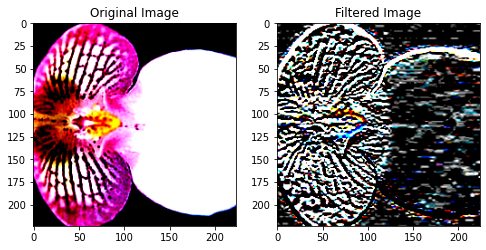

In [5]:
# Check if the filter has been applied properly to a random image
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(sobel_dataset_train[10]["original"].T, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(sobel_dataset_train[10]["sobel"].T, cmap='gray')
ax[1].set_title("Filtered Image")
plt.show()


In [3]:
class SobelNet(nn.Module):
    """
    PyTorch model class to apply Sobel filter to an image.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer with 3 input channels and 32 output channels, with kernel size of 3 and padding size of 1.
        conv2 (nn.Conv2d): Second convolutional layer with 32 input channels and 64 output channels, with kernel size of 3 and padding size of 1.
        conv3 (nn.Conv2d): Third convolutional layer with 64 input channels and 128 output channels, with kernel size of 3 and padding size of 1.
        conv4 (nn.Conv2d): Fourth convolutional layer with 128 input channels and 3 output channels, with kernel size of 3 and padding size of 1.

    """

    def __init__(self):
        """
        Initialize the model with the convolutional layers.
        """
        super(SobelNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 3, 3, padding=1)

    def forward(self, x):
        """
        Perform a forward pass of the model on the input image.

        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output image tensor of shape (batch_size, 3, height, width) with Sobel filter applied.

        """
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = self.conv4(x)
        return x


In [4]:
# Create the SobelNet model
model = SobelNet()
model.to(device)

SobelNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [7]:
num_epochs = 10
patience = 10
best_val_loss = float('inf')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainloader = torch.utils.data.DataLoader(
    sobel_dataset_train, batch_size=32, shuffle=True
)
valloader = torch.utils.data.DataLoader(sobel_dataset_val, batch_size=32, shuffle=True)

# Train the model
print("Starting training\n")
for epoch in range(num_epochs):

    train_loss, val_loss = 0.0, 0.0

    for batch_idx, batch in enumerate(trainloader):

        # Forward pass
        input_batch = batch["original"].to(device)
        pred_image = model(input_batch)
        sobel_output = batch["sobel"].to(device)

        # Compute loss
        loss = criterion(pred_image, sobel_output)

        # Zero gradients and perform a backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters
        optimizer.step()
       
        train_loss += loss.item()
        if batch_idx % 10 == 9:  # Print every 10 mini-batches
            
            model.eval()
            with torch.no_grad():
                for batch_idx, batch in enumerate(valloader):
                    val_ip_batch = batch["original"].to(device)
                    val_op_batch = batch["sobel"].to(device)
                    val_pred = model(val_ip_batch)
                    val_loss_item = criterion(val_pred, val_op_batch).item()
                    val_loss += val_loss_item

            train_loss /= len(trainloader.dataset)
            val_loss /= len(valloader.dataset)
            # Print statistics
            print(
                f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}"
            )

            # Check if the validation loss has improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_batches = 0
                if not os.path.exists("./poly/"):
                    os.mkdir("./poly/")
                torch.save(model.state_dict(), "poly/best_model.pt")
            else:
                no_improvement_batches += 1

            # Check if the patience has been reached
            if no_improvement_batches >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
            train_loss = 0.0

print("Finished Training")


Starting training

Epoch 1/10: Train Loss: 0.1924 Val Loss: 0.5342
Epoch 1/10: Train Loss: 0.1095 Val Loss: 0.2939
Epoch 1/10: Train Loss: 0.0784 Val Loss: 0.2181
Epoch 2/10: Train Loss: 0.0583 Val Loss: 0.1609
Epoch 2/10: Train Loss: 0.0460 Val Loss: 0.1362
Epoch 2/10: Train Loss: 0.0394 Val Loss: 0.1211
Epoch 3/10: Train Loss: 0.0362 Val Loss: 0.1070
Epoch 3/10: Train Loss: 0.0318 Val Loss: 0.0977
Epoch 3/10: Train Loss: 0.0292 Val Loss: 0.0869
Epoch 4/10: Train Loss: 0.0256 Val Loss: 0.0775
Epoch 4/10: Train Loss: 0.0237 Val Loss: 0.0698
Epoch 4/10: Train Loss: 0.0239 Val Loss: 0.0701
Epoch 5/10: Train Loss: 0.0206 Val Loss: 0.0600
Epoch 5/10: Train Loss: 0.0180 Val Loss: 0.0534
Epoch 5/10: Train Loss: 0.0172 Val Loss: 0.0560
Epoch 6/10: Train Loss: 0.0168 Val Loss: 0.0544
Epoch 6/10: Train Loss: 0.0146 Val Loss: 0.0411
Epoch 6/10: Train Loss: 0.0138 Val Loss: 0.0361
Epoch 7/10: Train Loss: 0.0104 Val Loss: 0.0313
Epoch 7/10: Train Loss: 0.0103 Val Loss: 0.0441
Epoch 7/10: Train Los

In [8]:
# Calculating loss on the test set, and ensuring that it is comparable
# and not disproportionately larger than training and validation losses.
testloader = torch.utils.data.DataLoader(sobel_dataset_test, batch_size=32, shuffle=True)
test_loss = 0.0
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(testloader):
        test_ip_batch = batch["original"].to(device)
        test_op_batch = batch["sobel"].to(device)
        test_pred = model(val_ip_batch)
        test_loss_item = criterion(val_pred, val_op_batch).item()
        test_loss += val_loss_item

test_loss /= len(testloader.dataset)
print(
    f"Test Set Loss: {test_loss:.4f}"
)

Test Set Loss: 0.0185


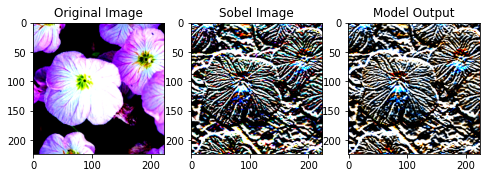

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].imshow(sobel_dataset_train[0]["original"].T, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(sobel_dataset_train[0]["sobel"].T, cmap='gray')
ax[1].set_title("Sobel Image")
op = model(sobel_dataset_train[0]["original"].to(device)).squeeze().cpu().detach().numpy()
ax[2].imshow(op.T, cmap='gray')
ax[2].set_title("Model Output")
plt.show()


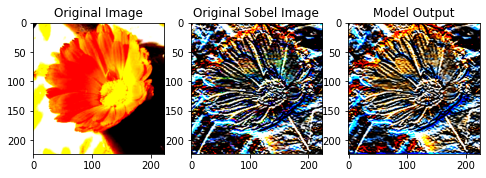

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].imshow(sobel_dataset_test[150]["original"].T, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(sobel_dataset_test[150]["sobel"].T, cmap='gray')
ax[1].set_title("Original Sobel Image")
op = model(sobel_dataset_test[150]["original"].to(device)).squeeze().cpu().detach().numpy()
ax[2].imshow(op.T, cmap='gray')
ax[2].set_title("Model Output")
plt.show()


ANSWERS TO QUESTIONS:

1) What if the image is really large or not of a standard size?
- We can use Pytorch transforms() to resize a large or non-standard image size, as shown on lines 25-28 in the first cell. The second option is to cut up the image and feed these different cuts to the model separately, and patch the model outputs. Since we are using a fully-convolutional architecture, we do not need to worry about non-standard sizes since there are no fully connected layers which are size dependent.

2) What should occur at the edges of the image?
- When using the torch.nn.Conv2d() function in PyTorch, the border pixels in an image can be handled in several ways. This is controlled by the "padding" parameter, which determines the size of the zero-padding to be applied to the input image before the convolution operation. If the padding is set to 0, no padding will be applied to the input. However, since we need the output image to have the same size as the input image, we add a padding of 1 pixel (of value 0) around all the borders. Since the kernel size is odd and the stride length is 1, the output of the convolution operation will have the same dimensions as the input.

3) Are you using a fully convolutional architecture?
- Yes, we use a fully convolutional architecture as mentioned in 1), since it allows us to handle inputs of arbitrary size, as they do not require a fixed input size like fully connected layers do. Moreover, they are more computationally efficient than the fully connected layers since they do not require dense matrix multiplications.

4) Are there optimizations built into your framework of choice (e.g. Pytorch) that can make this fast?
- Yes, PyTorch includes CUDA support which allows the use of GPUs to accelerate the computations, specially when using convolutional layers. A GPU has a significantly larger number of cores than a CPU, which allows for better parallel processing ability that speeds up the computation process. Moreover, the existence of automatic differentiation or *autodiff* greatly speeds up the computation of gradients during training.

5) What if you wanted to optimize specifically for model size?
- To optimize for model size, we can use *knowledge distillation* techniques such as teacher-student training which allows us to use a compressed model and transfer knowledge from a larger teacher model to a smaller student model.  Moreover, we can also use the technique of *quantization* which involves reducing the precision of the weights and activations in the network which reduces the number of bits required to store them.

6) How do you know when training is complete?
* One of the most common ways is to use *early stopping*. This involves monitoring the performance of the model on a validation set during training and stopping training when the validation performance starts to degrade.
* Another common approach is to set a maximum number of training epochs or a maximum amount of time for training and stopping training when the maximum is reached. 

In this code, we use the above two techniques for stopping the training process. Additionally we can also use a *learning rate schedule* that decreases the learning rate over time, when the learning rate reaches a certain small value, the training could be stopped.

7) What is the benefit of a deeper model in this case? When might there be a benefit for a deeper model (not with a sobel kernel but generally when thinking about image to image transformations)?
* Handling large and complex images: A deeper model can handle larger and more complex, diverse images (for eg. with varying light conditions) better by having multiple layers since the model can learn multiple levels of abstraction.







**EXTRA CREDIT QUESTION: Now generalize your algorithm so that it can learn any arbitrary image kernel-based filter. You could test this by randomizing the kernel. What are the limitations of this?**
- To generalize the algorithm so that it can learn any arbitrary image kernel-based filter, we need to modify the training process. In the current scenario, we are constructing a custom Dataset class which returns an original image and an image with the Sobel filter applied on it. Instead of using a fixed Sobel filter, we can use a random filter during each iteration of the training process. The learnable layer will learn the parameters of the random filter. During training, we feed the input image and the corresponding filtered image as ground truth to the network. The network will update its parameters to minimize the MSE loss. After training, the learnable layer's parameters will represent a filter that is able to produce the filtered image from the input image.
- The limitation of this approach is that it may not always be able to learn the correct filter. The accuracy of the learned filter depends on the quality of the training data and the random filter used during each iteration. If the training data is not representative of the distribution of images that the filter will be applied to in the future, the learned filter may not perform well. Additionally, if the random filter used during training is too different from the desired filter, it may not converge to the correct solution.


